# Merge original databases into a common dataframe, ready for duplicate detection.

Created on Mon Jul  3 12:53:15 2023

Author: Lucie Luecke

Update 06/11/2025 by LL: Tidied up and commented code for documentation tutorial.

Create a common database from multiple standardised databases, based on the *load notebooks*:
 - PAGES2k (load_pages2k.ipynb)
 - FE23 (Breitenmoser 14) (load_fe23.ipynb)
 - SISAL v3 (load_sisal.ipynb)
 - CH2k (load_ch2k.ipynb)
 - Iso2k (load_iso2k.ipynb)

This database is subject to duplicates, so please run the duplicate detection files on the output.

The dataframe has the data:

  - ```archiveType```
  - ```dataSetName```
  - ```datasetId```
  - ```geo_meanElev```
  - ```geo_meanLat```
  - ```geo_meanLon```
  - ```geo_siteName```
  - ```interpretation_direction``` (new in v2.0)
  - ```interpretation_variable```
  - ```interpretation_variableDetail```
  - ```interpretation_seasonality``` (new in v2.0)
  - ```originalDataURL```
  - ```originalDatabase```
  - ```paleoData_notes```
  - ```paleoData_proxy```
  - ```paleoData_sensorSpecies```
  - ```paleoData_units```
  - ```paleoData_values```
  - ```paleoData_variableName```
  - ```year```
  - ```yearUnits```


## Set up working environment

Make sure the repo_root is added correctly, it should be: your_root_dir/dod2k
This should be the working directory throughout this notebook (and all other notebooks).

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path

# Add parent directory to path (works from any notebook in notebooks/)
# the repo_root should be the parent directory of the notebooks folder
init_dir = Path().resolve()
# Determine repo root
if init_dir.name == 'dod2k': repo_root = init_dir
elif init_dir.parent.name == 'dod2k': repo_root = init_dir.parent
else: raise Exception('Please review the repo root structure (see first cell).')

# Update cwd and path only if needed
if os.getcwd() != str(repo_root):
    os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print(f"Repo root: {repo_root}")
if str(os.getcwd())==str(repo_root):
    print(f"Working directory matches repo root. ")

Repo root: /home/jupyter-lluecke/dod2k
Working directory matches repo root. 


In [2]:
# Import packages
import pandas as pd
import numpy as np

from dod2k_utilities import ut_functions as utf # contains utility functions
from dod2k_utilities import ut_plot as uplt # contains plotting functions

## Load compact dataframes

Define which datasets should be loaded:

In [3]:
dataset_names = ['pages2k', 'fe23', 'ch2k', 'iso2k', 'sisal' ]

Now load the dataframes and merge:

In [4]:
# read compact dataframes from all the single databases

print(dataset_names[0])
df = utf.load_compact_dataframe_from_csv(dataset_names[0])
print('length: ', len(df))

for ii, dn in enumerate(dataset_names[1:]):
    print(f'add {dn}')
    new_df = utf.load_compact_dataframe_from_csv(dn)
    df = pd.concat([df, new_df])
    print('length: ', len(df))

print('---------------')
print('RESULT:')
df.index = range(len(df))
print(df.info())

pages2k
length:  1364
add fe23
length:  4118
add ch2k
length:  4339
add iso2k
length:  4774
add sisal
length:  5320
---------------
RESULT:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5320 entries, 0 to 5319
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    5320 non-null   object 
 1   dataSetName                    5320 non-null   object 
 2   datasetId                      5320 non-null   object 
 3   geo_meanElev                   5221 non-null   float32
 4   geo_meanLat                    5320 non-null   float32
 5   geo_meanLon                    5320 non-null   float32
 6   geo_siteName                   5320 non-null   object 
 7   interpretation_direction       5320 non-null   object 
 8   interpretation_seasonality     5320 non-null   object 
 9   interpretation_variable        5320 non-null   object 
 10  interpretation_variableDetai

## change metadata

### OriginalDataURL

1. when writing OriginalDataURL, convert any ftp://ftp.ncdc to https://ncei :  e.g.

URL 1: ftp://ftp.ncdc.noaa.gov/pub/data/paleo/contributions_by_author/keigwin2005 

write to 
URL 1: https://ncei.noaa.gov/pub/data/paleo/contributions_by_author/keigwin2005 



In [5]:
for ii in df[[df['originalDataURL'].iloc[ii].startswith('ftp://ftp.ncdc') for ii in df.index]].index:
    print('before: ', df['originalDataURL'].iloc[ii])
    df.at[ii, 'originalDataURL'] = df.at[ii, 'originalDataURL'].replace('ftp://ftp.ncdc', 'https://ncei')
    print('after: ', df['originalDataURL'].iloc[ii])
    

before:  ftp://ftp.ncdc.noaa.gov/pub/data/paleo/paleolimnology/northamerica/canada/baffin/big-round2008.txt
after:  https://ncei.noaa.gov/pub/data/paleo/paleolimnology/northamerica/canada/baffin/big-round2008.txt




2. When writing OriginalDataURLs like this one:

https://www.ncdc.noaa.gov/cdo/f?p=519:1:784943880673501::::P1_STUDY_ID:10492  

rewrite to a URL that is valid, e.g. 

https://www.ncei.noaa.gov/access/paleo-search/study/10492

In [6]:
for ii in df[[df['originalDataURL'].iloc[ii].startswith('https://www.ncdc.noaa.gov/cdo') for ii in df.index]].index:
    print('before: ', df['originalDataURL'].iloc[ii])
    study_id=df.at[ii, 'originalDataURL'].split('STUDY_ID:')[-1]
    print('study_ID: ', study_id)
    df.at[ii, 'originalDataURL'] = f'https://www.ncei.noaa.gov/access/paleo-search/study/{study_id}'
    print('after: ', df['originalDataURL'].iloc[ii])
    

before:  https://www.ncdc.noaa.gov/cdo/f?p=519:1:::::P1_STUDY_ID:5472
study_ID:  5472
after:  https://www.ncei.noaa.gov/access/paleo-search/study/5472
before:  https://www.ncdc.noaa.gov/cdo/f?p=519:1:0::::P1_STUDY_ID:13174
study_ID:  13174
after:  https://www.ncei.noaa.gov/access/paleo-search/study/13174
before:  https://www.ncdc.noaa.gov/cdo/f?p=519:1:::::P1_STUDY_ID:8647
study_ID:  8647
after:  https://www.ncei.noaa.gov/access/paleo-search/study/8647
before:  https://www.ncdc.noaa.gov/cdo/f?p=519:1:0::::P1_STUDY_ID:13174
study_ID:  13174
after:  https://www.ncei.noaa.gov/access/paleo-search/study/13174


## save merged dataframe

### save pickle

In [7]:
db_name='all_merged'
df.name=db_name
os.makedirs(f'data/{db_name}/', exist_ok=True)

In [8]:
# save concatenate dataframe as db_merged
df.to_pickle(f'data/{db_name}/{db_name}_compact.pkl')

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5320 entries, 0 to 5319
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    5320 non-null   object 
 1   dataSetName                    5320 non-null   object 
 2   datasetId                      5320 non-null   object 
 3   geo_meanElev                   5221 non-null   float32
 4   geo_meanLat                    5320 non-null   float32
 5   geo_meanLon                    5320 non-null   float32
 6   geo_siteName                   5320 non-null   object 
 7   interpretation_direction       5320 non-null   object 
 8   interpretation_seasonality     5320 non-null   object 
 9   interpretation_variable        5320 non-null   object 
 10  interpretation_variableDetail  5320 non-null   object 
 11  originalDataURL                5320 non-null   object 
 12  originalDatabase               5320 non-null   o

### save csv

In [10]:
# save to a list of csv files (metadata, data, year)
utf.write_compact_dataframe_to_csv(df)

METADATA: datasetId, archiveType, dataSetName, geo_meanElev, geo_meanLat, geo_meanLon, geo_siteName, interpretation_direction, interpretation_seasonality, interpretation_variable, interpretation_variableDetail, originalDataURL, originalDatabase, paleoData_notes, paleoData_proxy, paleoData_sensorSpecies, paleoData_units, paleoData_variableName, yearUnits
Saved to /home/jupyter-lluecke/dod2k/data/all_merged/all_merged_compact_%s.csv


In [11]:
# load dataframe
print(utf.load_compact_dataframe_from_csv(db_name).info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5320 entries, 0 to 5319
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    5320 non-null   object 
 1   dataSetName                    5320 non-null   object 
 2   datasetId                      5320 non-null   object 
 3   geo_meanElev                   5221 non-null   float32
 4   geo_meanLat                    5320 non-null   float32
 5   geo_meanLon                    5320 non-null   float32
 6   geo_siteName                   5320 non-null   object 
 7   interpretation_direction       5320 non-null   object 
 8   interpretation_seasonality     5320 non-null   object 
 9   interpretation_variable        5320 non-null   object 
 10  interpretation_variableDetail  5320 non-null   object 
 11  originalDataURL                5320 non-null   object 
 12  originalDatabase               5320 non-null   o

## Visualise dataframe

Show spatial distribution of records, show archive and proxy types

0 Wood 3757
1 Speleothem 591
2 Coral 455
3 GlacierIce 198
4 MarineSediment 169
5 LakeSediment 119
6 Documents 13
7 GroundIce 6
8 Sclerosponge 6
9 Borehole 3
10 Other 2
11 MolluskShell 1


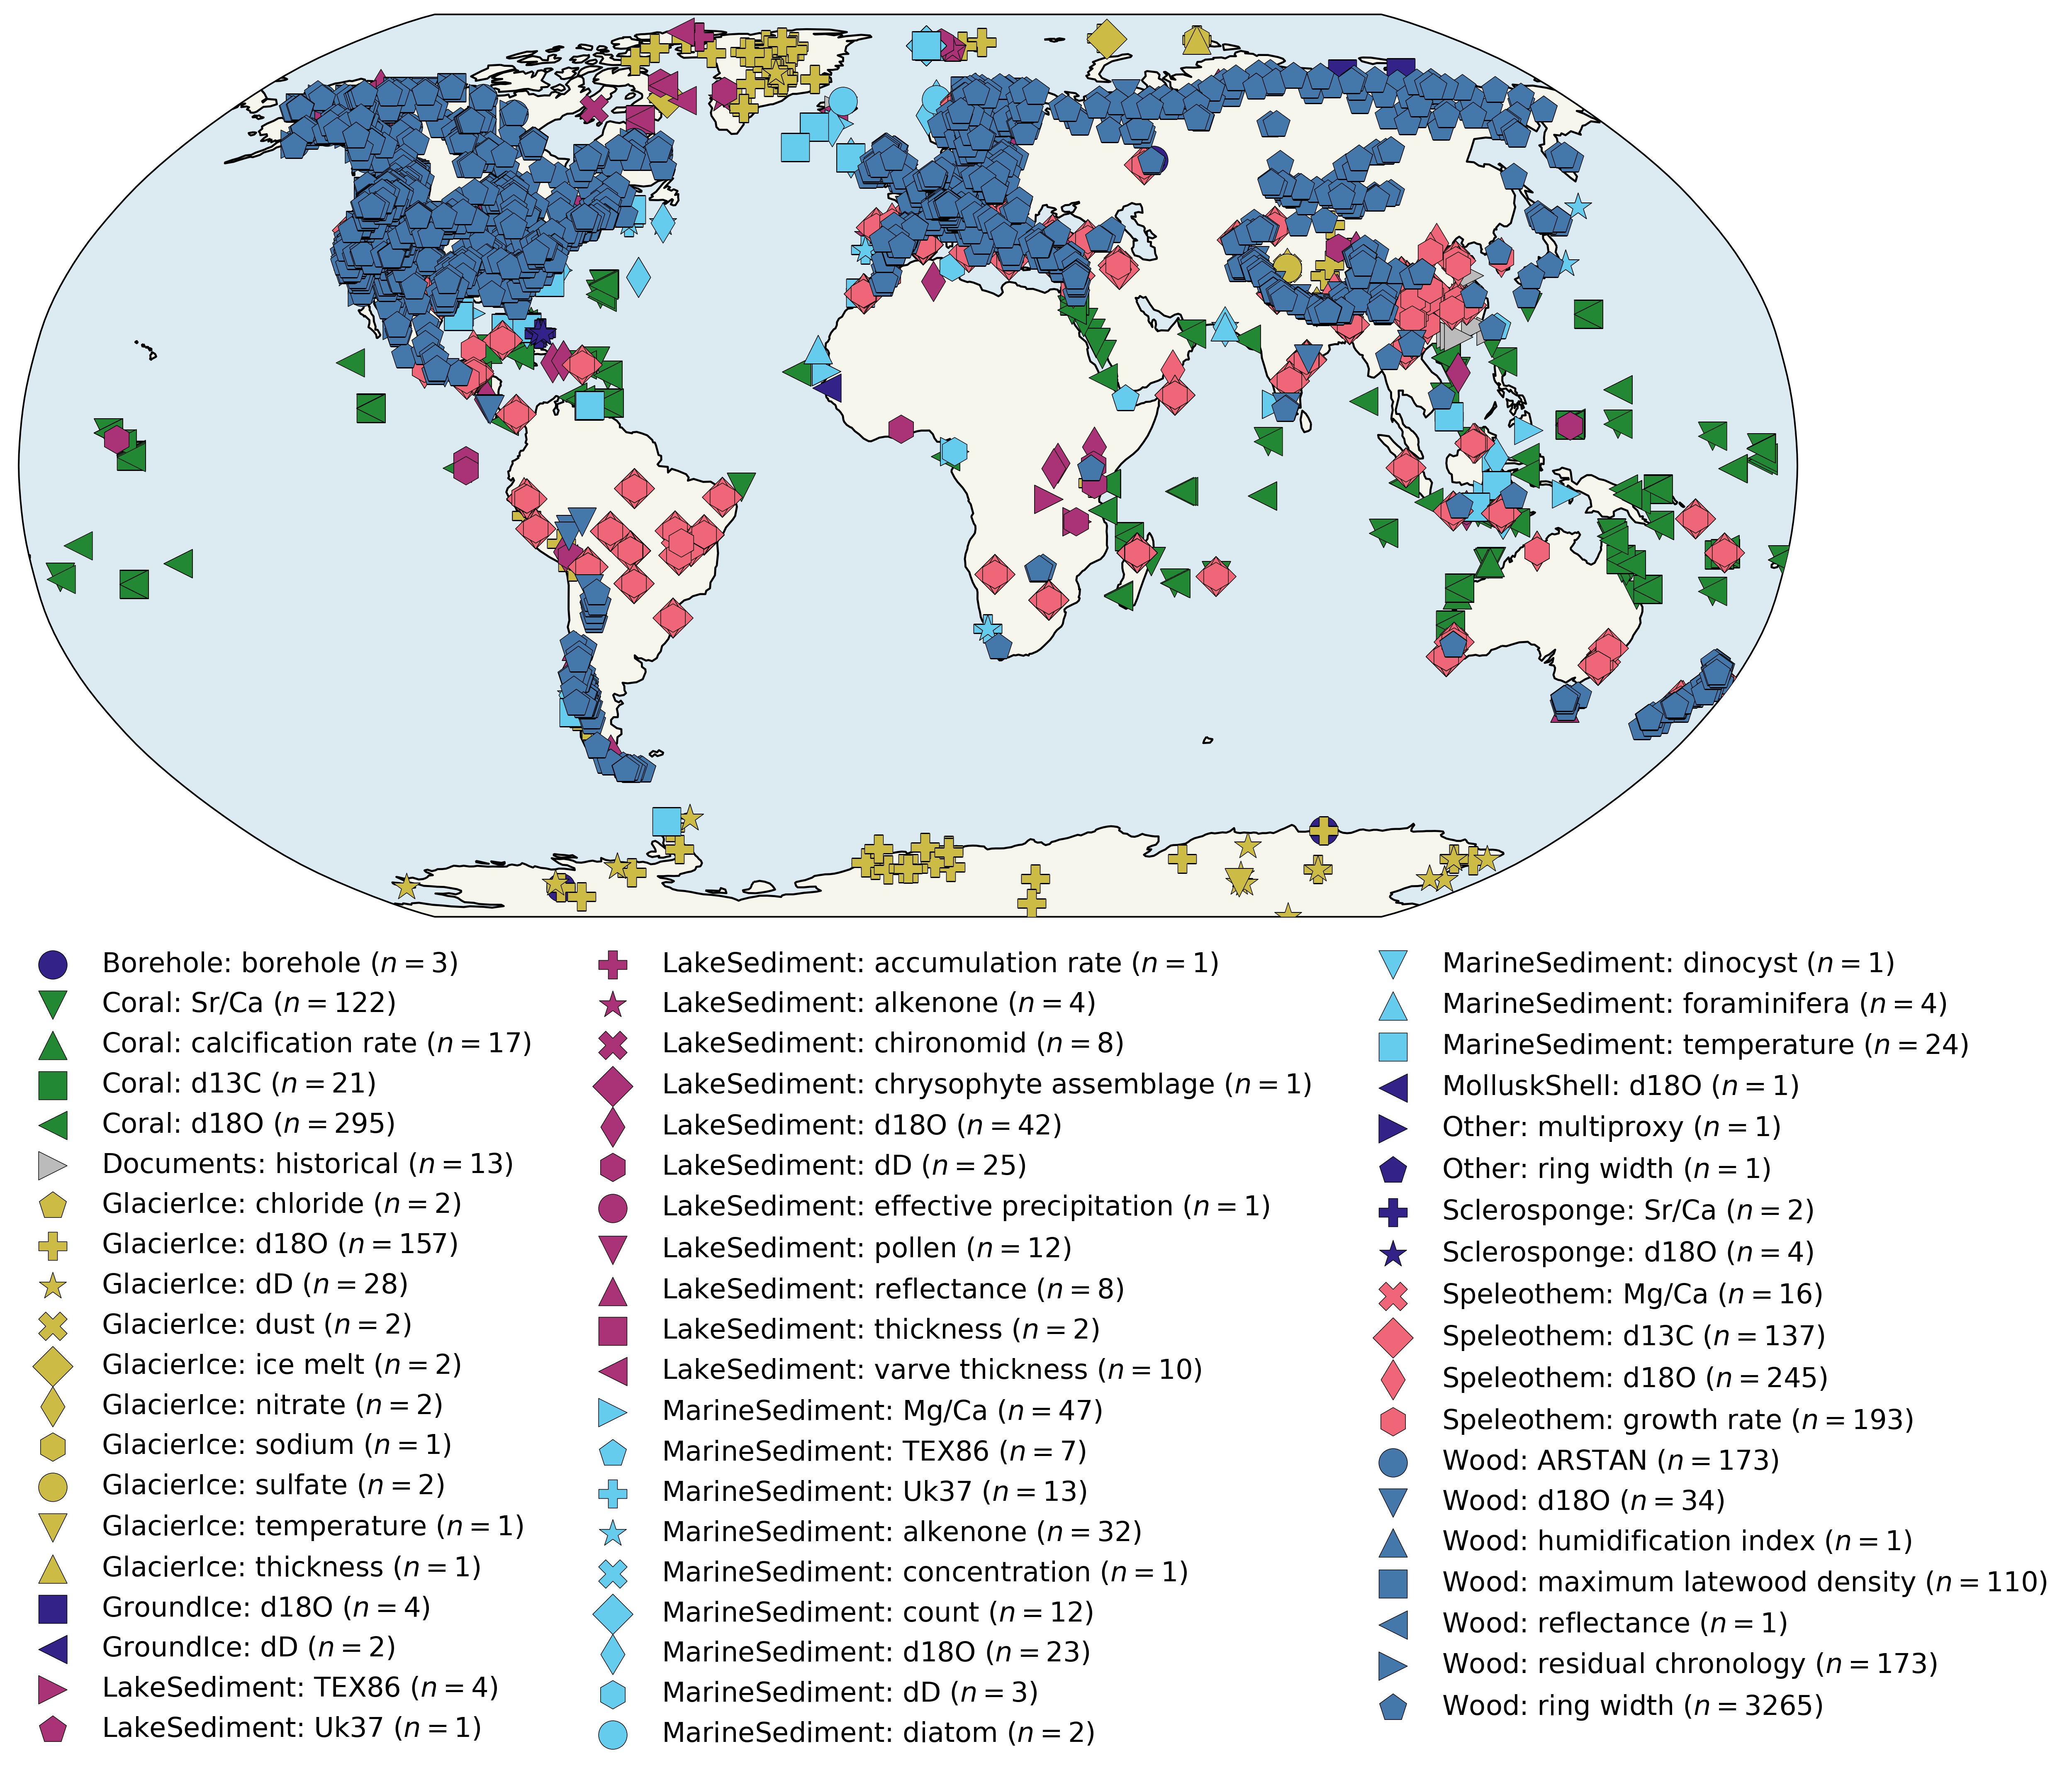

In [12]:
# count archive types
archive_count = {}
for ii, at in enumerate(set(df['archiveType'])):
    archive_count[at] = df.loc[df['archiveType']==at, 'archiveType'].count()

sort = np.argsort([cc for cc in archive_count.values()])
archives_sorted = np.array([cc for cc in archive_count.keys()])[sort][::-1]

# Specify colour for each archive (smaller archives get grouped into the same colour)
archive_colour, major_archives, other_archives = uplt.get_archive_colours(archives_sorted, archive_count)

fig = uplt.plot_geo_archive_proxy(df, archive_colour)

Now plot the coverage over the Common Era

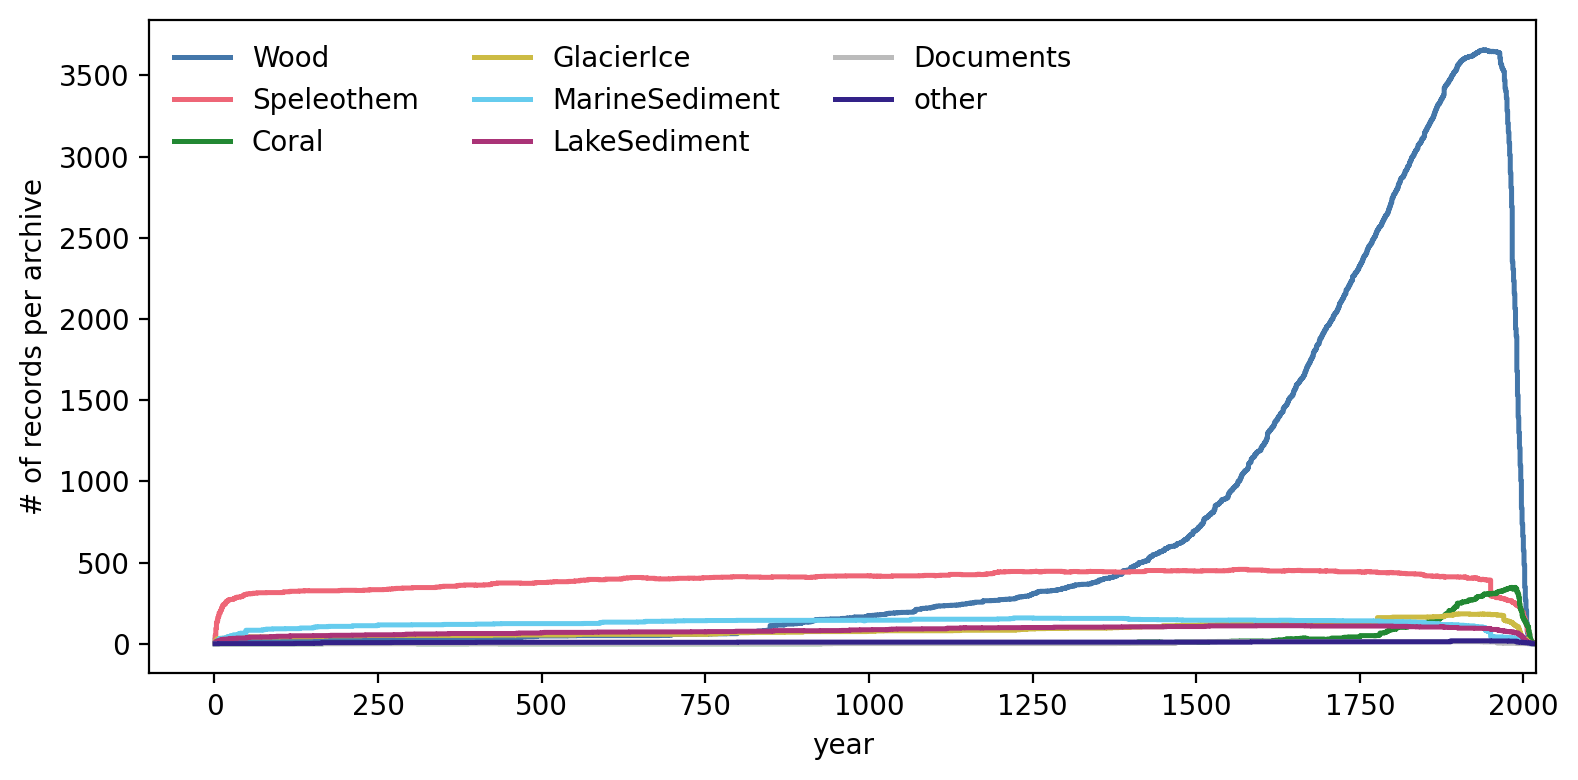

In [13]:
fig = uplt.plot_coverage(df, archives_sorted, major_archives, other_archives, archive_colour)

## Display dataframe

### Display identification metadata: dataSetName, datasetId, originalDataURL, originalDatabase

#### index

In [14]:
# # check index
print(df.index)

RangeIndex(start=0, stop=5320, step=1)


#### dataSetName (associated with each record, may not be unique)

In [15]:
# # check dataSetName
key = 'dataSetName'
print('%s: '%key)
print(df[key].values)
print(np.unique([str(type(dd)) for dd in df[key]]))

dataSetName: 
['Ant-WDC05A.Steig.2013' 'NAm-MtLemon.Briffa.2002'
 'NAm-MtLemon.Briffa.2002' ... 'Sahiya cave' 'Sahiya cave' 'Sahiya cave']
["<class 'str'>"]


#### datasetId (unique identifier, as given by original authors, includes original database token)

In [16]:
# # check datasetId

print(len(df.datasetId.unique()))
print(len(df))
key = 'datasetId'
print('%s (starts with): '%key)
print(df[key].values)
print(np.unique([str(type(dd)) for dd in df[key]]))
print('datasetId starts with: ', np.unique([str(dd.split('_')[0]) for dd in df[key]]))

5320
5320
datasetId (starts with): 
['pages2k_0' 'pages2k_5' 'pages2k_6' ... 'sisal_901.0_543'
 'sisal_901.0_544' 'sisal_901.0_545']
["<class 'str'>"]
datasetId starts with:  ['FE23' 'ch2k' 'iso2k' 'pages2k' 'sisal']


#### originalDataURL (URL/DOI of original published record where available)

In [17]:
# originalDataURL
key = 'originalDataURL'
print('%s: '%key)
print(np.unique([kk for kk in df[key]]))
print(np.unique([kk for kk in df[key] if 'this' in kk]))
print(np.unique([str(type(dd)) for dd in df[key]]))
# 'this study' should point to the correct URL (PAGES2k)

originalDataURL: 
['This compilation' "['10.1002/2015GL063826']" "['10.1002/2015gl065397']"
 ... 'this compilation' 'www.ncdc.noaa.gov/paleo-search/study/27330'
 'www.ncdc.noaa.gov/paleo/study/2474']
['this compilation']
["<class 'str'>"]


#### originalDatabase (original database used as input for dataframe)

In [18]:
# # originalDataSet
key = 'originalDatabase'
print('%s: '%key)
print(np.unique([kk for kk in df[key]]))
print(np.unique([str(type(dd)) for dd in df[key]]))
# Note: the last two records have missing URLs

originalDatabase: 
['CoralHydro2k v1.0.1' 'FE23 (Breitenmoser et al. (2014))' 'Iso2k v1.1.2'
 'PAGES 2k v2.2.0' 'SISAL v3']
["<class 'str'>"]


### geographical metadata: elevation, latitude, longitude, site name

#### geo_meanElev (mean elevation in m)

In [19]:
# check Elevation
key = 'geo_meanElev'
print('%s: '%key)
print(df[key])
print(np.unique(['%d'%kk for kk in df[key] if np.isfinite(kk)]))
print(np.unique([str(type(dd)) for dd in df[key]]))

geo_meanElev: 
0       1806.0
1       2700.0
2       2700.0
3       2700.0
4       2700.0
         ...  
5315    1190.0
5316    1190.0
5317    1190.0
5318    1190.0
5319    1190.0
Name: geo_meanElev, Length: 5320, dtype: float32
['-1' '-10' '-1011' ... '991' '994' '995']
["<class 'float'>"]


#### geo_meanLat (mean latitude in degrees N)

In [20]:
# # Latitude
key = 'geo_meanLat'
print('%s: '%key)
print(np.unique(['%d'%kk for kk in df[key]]))
print(np.unique([str(type(dd)) for dd in df[key]]))

geo_meanLat: 
['-1' '-10' '-11' '-12' '-13' '-14' '-15' '-16' '-17' '-18' '-19' '-20'
 '-21' '-22' '-23' '-24' '-25' '-26' '-27' '-28' '-29' '-3' '-31' '-32'
 '-33' '-34' '-35' '-36' '-37' '-38' '-39' '-4' '-40' '-41' '-42' '-43'
 '-44' '-45' '-46' '-47' '-5' '-50' '-51' '-53' '-54' '-6' '-64' '-66'
 '-69' '-7' '-70' '-71' '-72' '-73' '-74' '-75' '-76' '-77' '-78' '-79'
 '-8' '-82' '-84' '-89' '-9' '0' '1' '10' '11' '12' '13' '15' '16' '17'
 '18' '19' '2' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '3' '30'
 '31' '32' '33' '34' '35' '36' '37' '38' '39' '4' '40' '41' '42' '43' '44'
 '45' '46' '47' '48' '49' '5' '50' '51' '52' '53' '54' '55' '56' '57' '58'
 '59' '6' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '7' '70' '71'
 '72' '73' '75' '76' '77' '78' '79' '8' '80' '81' '82' '9']
["<class 'float'>"]


### geo_meanLon (mean longitude)

In [21]:
# # Longitude 
key = 'geo_meanLon'
print('%s: '%key)
print(np.unique(['%d'%kk for kk in df[key]]))
print(np.unique([str(type(dd)) for dd in df[key]]))

geo_meanLon: 
['-1' '-10' '-100' '-101' '-102' '-103' '-104' '-105' '-106' '-107' '-108'
 '-109' '-110' '-111' '-112' '-113' '-114' '-115' '-116' '-117' '-118'
 '-119' '-12' '-120' '-121' '-122' '-123' '-124' '-125' '-126' '-127'
 '-128' '-129' '-13' '-130' '-131' '-132' '-133' '-134' '-135' '-136'
 '-137' '-138' '-139' '-140' '-141' '-142' '-143' '-144' '-145' '-146'
 '-147' '-148' '-149' '-150' '-151' '-152' '-153' '-154' '-157' '-159'
 '-16' '-160' '-161' '-162' '-163' '-169' '-17' '-174' '-18' '-19' '-2'
 '-22' '-24' '-26' '-27' '-3' '-33' '-35' '-36' '-37' '-38' '-39' '-4'
 '-41' '-42' '-43' '-44' '-45' '-46' '-47' '-49' '-5' '-50' '-51' '-54'
 '-55' '-56' '-57' '-58' '-6' '-60' '-61' '-62' '-63' '-64' '-65' '-66'
 '-67' '-68' '-69' '-7' '-70' '-71' '-72' '-73' '-74' '-75' '-76' '-77'
 '-78' '-79' '-8' '-80' '-81' '-82' '-83' '-84' '-85' '-86' '-87' '-88'
 '-89' '-9' '-90' '-91' '-92' '-93' '-94' '-95' '-96' '-97' '-98' '-99'
 '0' '1' '10' '100' '101' '102' '103' '104' '105' '106'

#### geo_siteName (name of collection site)

In [22]:
# Site Name 
key = 'geo_siteName'
print('%s: '%key)
print(df[key].values)
print(np.unique([str(type(dd)) for dd in df[key]]))

geo_siteName: 
['WDC05A' 'Mt. Lemon' 'Mt. Lemon' ... 'Sahiya cave' 'Sahiya cave'
 'Sahiya cave']
["<class 'str'>"]


### proxy metadata: archive type, proxy type, interpretation

#### archiveType (archive type)

In [23]:
# archiveType
key = 'archiveType'
print('%s: '%key)
print(np.unique(df[key]))
print(np.unique([str(type(dd)) for dd in df[key]]))

archiveType: 
['Borehole' 'Coral' 'Documents' 'GlacierIce' 'GroundIce' 'LakeSediment'
 'MarineSediment' 'MolluskShell' 'Other' 'Sclerosponge' 'Speleothem'
 'Wood']
["<class 'str'>"]


#### paleoData_proxy (proxy type)

In [24]:
# paleoData_proxy
key = 'paleoData_proxy'
print('%s: '%key)
print(np.unique([kk for kk in df[key]]))
print(np.unique([str(type(dd)) for dd in df[key]]))

paleoData_proxy: 
['ARSTAN' 'Mg/Ca' 'Sr/Ca' 'TEX86' 'Uk37' 'accumulation rate' 'alkenone'
 'borehole' 'calcification rate' 'chironomid' 'chloride'
 'chrysophyte assemblage' 'concentration' 'count' 'd13C' 'd18O' 'dD'
 'diatom' 'dinocyst' 'dust' 'effective precipitation' 'foraminifera'
 'growth rate' 'historical' 'humidification index' 'ice melt'
 'maximum latewood density' 'multiproxy' 'nitrate' 'pollen' 'reflectance'
 'residual chronology' 'ring width' 'sodium' 'sulfate' 'temperature'
 'thickness' 'varve thickness']
["<class 'str'>"]


#### paleoData_sensorSpecies (further information on proxy type: species)

In [25]:
# climate_interpretation
key = 'paleoData_sensorSpecies'
print('%s: '%key)
print(np.unique([kk for kk in df[key]]))
print(np.unique([str(type(dd)) for dd in df[key]]))


paleoData_sensorSpecies: 
['ABAL' 'ABAM' 'ABBA' 'ABBO' 'ABCE' 'ABCI' 'ABCO' 'ABLA' 'ABMA' 'ABPI'
 'ABPN' 'ABPR' 'ABSB' 'ABSP' 'ACRU' 'ACSH' 'ADHO' 'ADUS' 'AGAU' 'ARAR'
 'ATCU' 'ATSE' 'AUCH' 'BEPU' 'CABU' 'CADE' 'CADN' 'CARO' 'CDAT' 'CDBR'
 'CDDE' 'CDLI' 'CEAN' 'CESP' 'CHLA' 'CHNO' 'Ceratoporella nicholsoni'
 'DABI' 'DACO' 'Diploastrea heliopora' 'Diploria labyrinthiformis'
 'Diploria strigosa' 'FAGR' 'FASY' 'FICU' 'FRNI' 'Favia speciosa' 'HABI'
 'Hydnophora microconos, Porites lobata' 'JGAU' 'JUEX' 'JUFO' 'JUOC'
 'JUPH' 'JUPR' 'JURE' 'JUSC' 'JUSP' 'JUVI' 'LADE' 'LAGM' 'LALA' 'LALY'
 'LAOC' 'LASI' 'LGFR' 'LIBI' 'LITU' 'Montastraea faveolata' 'N/A' 'NA'
 'NOBE' 'NOGU' 'NOME' 'NOPU' 'NOSO' 'NaN' 'Orbicella faveolata'
 'P. australiensis, possibly P. lobata' 'PCAB' 'PCEN' 'PCGL' 'PCGN' 'PCMA'
 'PCOB' 'PCOM' 'PCPU' 'PCRU' 'PCSH' 'PCSI' 'PCSM' 'PCSP' 'PHAL' 'PHAS'
 'PHGL' 'PHTR' 'PIAL' 'PIAM' 'PIAR' 'PIBA' 'PIBN' 'PIBR' 'PICE' 'PICL'
 'PICO' 'PIEC' 'PIED' 'PIFL' 'PIHA' 'PIHR' 'PIJE' 'PIKO' 'P

#### paleoData_notes (notes)

In [26]:
# # paleoData_notes
key = 'paleoData_notes'
print('%s: '%key)
print(df[key].values)
print(np.unique([str(type(dd)) for dd in df[key]]))

paleoData_notes: 
['; climateInterpretation_seasonality changed - was originally Mean annual values; archiveType changed - was originally ice core'
 'nan' 'nan' ... 'calcite' 'calcite' 'calcite']
["<class 'str'>"]


#### paleoData_variableName

In [27]:
# paleoData_variableName
key = 'paleoData_variableName'
print('%s: '%key)
print(np.unique([kk for kk in df[key]]))
print(np.unique([str(type(dd)) for dd in df[key]]))

paleoData_variableName: 
['ARSTAN' 'MAR' 'Mg/Ca' 'R650/R700' 'RABD660670' 'Sr/Ca' 'TEX86' 'Uk37'
 'calcification rate' 'chloride' 'composite' 'concentration' 'count'
 'd13C' 'd18O' 'd2H' 'dD' 'dust' 'effective precipitation' 'growth rate'
 'humidification index' 'ice melt' 'maximum latewood density' 'nitrate'
 'precipitation' 'reflectance' 'residual chronology' 'ring width' 'sodium'
 'sulfate' 'temperature' 'thickness' 'varve thickness' 'year']
["<class 'str'>"]


### climate metadata: interpretation variable, direction, seasonality

#### interpretation_direction

In [28]:
# climate_interpretation
key = 'interpretation_direction'
print('%s: '%key)
print(np.unique([kk for kk in df[key]]))
print(f'No. of unique values: {len(np.unique(df[key]))}/{len(df)}')

interpretation_direction: 
['Increase' 'N/A' 'NaN' 'None' 'T_air (positive), P_amount (negative)'
 'T_air (positive), P_amount (negative), SPEI (negative)' 'decrease'
 'decrease/increase'
 'depends (orbital timescale: More Indian Monsoon moisture-->more enriched. Since 3ka: Indian source has been stable, so amount effect dominates: more rainfall, more intense hydrological cycle -->More depleted)'
 'increase' 'negaitive' 'negative' 'positive'
 'positive for d18O-temperature relation, negative for d13C-precipiation amount']
No. of unique values: 14/5320


#### interpretation_seasonality

In [29]:
# climate_interpretation
key = 'interpretation_seasonality'
print('%s: '%key)
print(np.unique([kk for kk in df[key]]))
print(f'No. of unique values: {len(np.unique(df[key]))}/{len(df)}')

interpretation_seasonality: 
['Annual' 'Apr' 'Apr-Jul' 'Apr-Jun' 'Apr-Sep' 'Aug' 'Aug-Jul' 'Dec-Feb'
 'Dec-Mar' 'Dec-May' 'Feb' 'Feb-Aug' 'Growing Season' 'Jan' 'Jan-Apr'
 'Jan-Jun' 'Jan-Mar' 'Jul' 'Jul-Dec' 'Jul-Sep' 'Jun' 'Jun-Aug' 'Jun-Jul'
 'Jun-Sep' 'Mar' 'Mar-Aug' 'Mar-May' 'Mar-Nov' 'Mar-Oct' 'May' 'May-Apr'
 'May-Dec' 'May-Jul' 'May-Oct' 'May-Sep' 'N/A' 'None' 'Nov-Apr' 'Nov-Feb'
 'Nov-Jan' 'Nov-Oct' 'Oct-Apr' 'Oct-Dec' 'Oct-Sep' 'Sep-Apr' 'Sep-Aug'
 'Sep-Nov' 'Sep-Oct' 'Spr-Sum' 'Summer' 'Wet Season' 'Winter' 'deleteMe'
 'subannual']
No. of unique values: 54/5320


#### interpretation_variable

In [30]:
# climate_interpretation
key = 'interpretation_variable'
print('%s: '%key)
print(np.unique([kk for kk in df[key]]))
print(f'No. of unique values: {len(np.unique(df[key]))}/{len(df)}')

interpretation_variable: 
['N/A' 'NOT temperature NOT moisture' 'moisture' 'temperature'
 'temperature+moisture']
No. of unique values: 5/5320


#### interpretation_variableDetail

In [31]:
# climate_interpretation
key = 'interpretation_variableDetail'
print('%s: '%key)
print(np.unique([kk for kk in df[key]]))
print(f'No. of unique values: {len(np.unique(df[key]))}/{len(df)}')

interpretation_variableDetail: 
['0.58 +- 0.11ppt/degrees C'
 'Changes in annual temperature modulated by oceanic circulation and gradients'
 'Maximum air temperature, seasonal' 'Maximum temperature' 'N/A' 'NaN'
 'None'
 'Original interpretation_variable: circulationIndex, interpretation_variableDetail: lake water'
 'Original interpretation_variable: circulationVariable, interpretation_variableDetail: Indian monsoon'
 'Original interpretation_variable: circulationVariable, interpretation_variableDetail: More negative d18O values correspond to stronger amount'
 'Original interpretation_variable: circulationVariable, interpretation_variableDetail: N/A'
 'Original interpretation_variable: circulationVariable, interpretation_variableDetail: tropical or North Pacific moisture'
 'Original interpretation_variable: deleteMe, interpretation_variableDetail: N/A'
 'Original interpretation_variable: deleteMe, interpretation_variableDetail: more positive values of d13C indicate a spread of C4 prair

### data 

#### paleoData_values

In [32]:
# # paleoData_values
key = 'paleoData_values'

print('%s: '%key)
for ii, vv in enumerate(df[key][:20]):
    try: 
        print('%-30s: %s -- %s'%(df['dataSetName'].iloc[ii][:30], str(np.nanmin(vv)), str(np.nanmax(vv))))
        print(type(vv))
    except: print(df['dataSetName'].iloc[ii], 'NaNs detected.')
print(np.unique([str(type(dd)) for dd in df[key]]))

paleoData_values: 
Ant-WDC05A.Steig.2013         : -37.1463 -- -30.6851
<class 'numpy.ndarray'>
NAm-MtLemon.Briffa.2002       : 0.154 -- 2.91
<class 'numpy.ndarray'>
NAm-MtLemon.Briffa.2002       : 0.205 -- 1.813
<class 'numpy.ndarray'>
NAm-MtLemon.Briffa.2002       : 0.245 -- 1.655
<class 'numpy.ndarray'>
NAm-MtLemon.Briffa.2002       : 0.283 -- 1.666
<class 'numpy.ndarray'>
NAm-MtLemon.Briffa.2002       : 0.574 -- 0.951
<class 'numpy.ndarray'>
NAm-MtLemon.Briffa.2002       : 0.707 -- 1.118
<class 'numpy.ndarray'>
NAm-MtLemon.Briffa.2002       : 0.789 -- 1.102
<class 'numpy.ndarray'>
NAm-MtLemon.Briffa.2002       : 0.757 -- 1.114
<class 'numpy.ndarray'>
Arc-Arjeplog.Bjorklund.2014   : -3.532171 -- 2.5670047
<class 'numpy.ndarray'>
Arc-Arjeplog.Bjorklund.2014   : -4.1141653 -- 2.6139
<class 'numpy.ndarray'>
Asi-CHIN019.Li.2010           : 0.298 -- 1.664
<class 'numpy.ndarray'>
NAm-Landslide.Luckman.2006    : 0.057 -- 0.76
<class 'numpy.ndarray'>
NAm-Landslide.Luckman.2006    : 0.164 --

#### paleoData_units

In [33]:
# paleoData_units
key = 'paleoData_units'
print('%s: '%key)
print(np.unique([kk for kk in df[key]]))
print(np.unique([str(type(dd)) for dd in df[key]]))

paleoData_units: 
['cm' 'cm/yr' 'count' 'count/mL' 'degC' 'g/cm/yr' 'g/cm2/yr' 'g/cm3' 'mm'
 'mm/year' 'mm/yr' 'mmol/mol' 'nan' 'needsToBeChanged' 'ng/g' 'percent'
 'permil' 'ppb' 'standardized_anomalies' 'unitless' 'yr AD' 'z score']
["<class 'str'>"]


#### year

In [34]:
# # year
key = 'year'
print('%s: '%key)
for ii, vv in enumerate(df[key][:20]):
    try: print('%-30s: %s -- %s'%(df['dataSetName'].iloc[ii][:30], str(np.nanmin(vv)), str(np.nanmax(vv))))
    except: print('NaNs detected.', vv)
print(np.unique([str(type(dd)) for dd in df[key]]))

year: 
Ant-WDC05A.Steig.2013         : 786.0 -- 2005.0
NAm-MtLemon.Briffa.2002       : 1568.0 -- 1983.0
NAm-MtLemon.Briffa.2002       : 1568.0 -- 1983.0
NAm-MtLemon.Briffa.2002       : 1568.0 -- 1983.0
NAm-MtLemon.Briffa.2002       : 1568.0 -- 1983.0
NAm-MtLemon.Briffa.2002       : 1568.0 -- 1983.0
NAm-MtLemon.Briffa.2002       : 1568.0 -- 1983.0
NAm-MtLemon.Briffa.2002       : 1568.0 -- 1983.0
NAm-MtLemon.Briffa.2002       : 1568.0 -- 1983.0
Arc-Arjeplog.Bjorklund.2014   : 1200.0 -- 2010.0
Arc-Arjeplog.Bjorklund.2014   : 1200.0 -- 2010.0
Asi-CHIN019.Li.2010           : 1509.0 -- 2006.0
NAm-Landslide.Luckman.2006    : 913.0 -- 2001.0
NAm-Landslide.Luckman.2006    : 913.0 -- 2001.0
NAm-Landslide.Luckman.2006    : 913.0 -- 2001.0
NAm-Landslide.Luckman.2006    : 913.0 -- 2001.0
NAm-SmithersSkiArea.Schweingru: 1680.0 -- 1983.0
NAm-SmithersSkiArea.Schweingru: 1680.0 -- 1983.0
NAm-SmithersSkiArea.Schweingru: 1680.0 -- 1983.0
NAm-SmithersSkiArea.Schweingru: 1680.0 -- 1983.0
["<class 'numpy.nd

#### yearUnits

In [35]:
# yearUnits
key = 'yearUnits'
print('%s: '%key)
print(np.unique([kk for kk in df[key]]))
print(np.unique([str(type(dd)) for dd in df[key]]))

yearUnits: 
['CE']
["<class 'str'>"]
